### Deep Neural Network for SOC Prediction with using Panasonic 18650PF Li-ion Battery

Panasonic 18650PF Li-ion Battery DataSet - https://data.mendeley.com/datasets/wykht8y7tg/1

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import optuna
import time
from optuna.visualization import plot_optimization_history
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
PROCESSED_DATA_DIR = '../../datasets/Panasonic_dataset/Panasonic_processed'
FEATURE_COLS = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Voltage Average', 'Current Average', 'Power [W]', 'Cumulative_Capacity_Ah']
LABEL_COL = 'SOC [-]'
BATCH_SIZE = 1024
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Function to load data
def load_data(directory, temperatures):
    frames = []    
    for temp_folder in os.listdir(directory):
        if temp_folder in temperatures:
            temp_path = os.path.join(directory, temp_folder)
            for file in os.listdir(temp_path):
                if 'Charge' in file or 'Dis' in file:
                    continue  # Skip constant charge and discharge files
                if file.endswith('.csv'):
                    df = pd.read_csv(os.path.join(temp_path, file))
                    df['SourceFile'] = file

                    # Calculate power
                    df['Power [W]'] = df['Voltage [V]'] * df['Current [A]']
                    
                    frames.append(df)
    return pd.concat(frames, ignore_index=True)

In [4]:
# Create Dataset
class BatteryDatasetDNN(Dataset):
    def __init__(self, data_tensor, labels_tensor, filenames=None, times=None):
        self.features = data_tensor
        self.labels = labels_tensor
        self.filenames = filenames 
        self.times = times 

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        filename = self.filenames[idx]
        time = self.times[idx]  
        return feature, label, filename, time
    
    def get_unique_filenames(self):
        return set(self.filenames)
    
    def get_times(self):
        return self.times

In [5]:
# DNN Model
class SoCDNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout = 0.1):
        super(SoCDNN, self).__init__()

        self.hidden_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList()

        # First layer
        self.hidden_layers.append(nn.Linear(input_size, hidden_size))
        self.batch_norm_layers.append(nn.BatchNorm1d(hidden_size))

        # Dynamically add hidden layers
        for i in range(1, num_layers):
            layer_size = hidden_size // (2 ** i)
            self.hidden_layers.append(nn.Linear(hidden_size // (2 ** (i - 1)), layer_size))
            self.batch_norm_layers.append(nn.BatchNorm1d(layer_size))

        # Output layer
        self.output_layer = nn.Linear(hidden_size // (2 ** (num_layers - 1)), 1)

        # Activation and Dropout against Regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        for hidden_layer, batch_norm_layer in zip(self.hidden_layers, self.batch_norm_layers):
            x = self.relu(batch_norm_layer(hidden_layer(x)))
            x = self.dropout(x)

        x = self.output_layer(x)
        return x


In [6]:
# Training loop with validation
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, epochs, device, patience=5, min_delta=0.0001):
    history = {'train_loss': [], 'val_loss': []}

    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        epoch_start_time = time.time()
        for _, (sequences, labels, _, _) in enumerate(tqdm(train_loader, desc=f'Epoch: {epoch}/{epochs}')):  
            sequences, labels = sequences.to(device), labels.to(device)
            labels = labels.unsqueeze(1) 
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for sequences, labels, _, _ in val_loader:  
                sequences, labels = sequences.to(device), labels.to(device)
                labels = labels.unsqueeze(1)  
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)

        # Early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
        print(f'Time taken for epoch: {epoch_time:.8f} seconds')

        if epochs_no_improve >= patience:
            print('Early stopping triggered')
            #break

    return history

In [7]:
temperatures_to_process = [folder for folder in os.listdir(PROCESSED_DATA_DIR) if 'degC' in folder]

In [8]:
data = load_data(PROCESSED_DATA_DIR, temperatures_to_process)
data

,Timestamp,Time [s],Voltage [V],Current [A],Temperature [degC],Capacity [Ah],Voltage Average,Current Average,Time_diff,Cumulative_Capacity_Ah,SOC [-],SourceFile,Power [W]
0,2017-05-30 20:17:33,50.000000,3.86277,-2.23754,0.754623,-0.02364,3.895890,-1.700817,0.000029,-0.023551,0.990977,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-8.643102
1,2017-05-30 20:17:33,50.097998,3.84797,-2.27755,0.754623,-0.02371,3.895549,-1.699886,0.000027,-0.023613,0.990953,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-8.763944
2,2017-05-30 20:17:33,50.198993,3.84025,-2.29470,0.754623,-0.02377,3.895338,-1.698867,0.000028,-0.023677,0.990929,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-8.812222
3,2017-05-30 20:17:33,50.296991,3.83575,-2.30205,0.754623,-0.02384,3.895206,-1.697771,0.000027,-0.023740,0.990905,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-8.830088
4,2017-05-30 20:17:33,50.398992,3.83317,-2.30613,0.754623,-0.02390,3.895125,-1.696615,0.000028,-0.023805,0.990880,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-8.839788
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3728549,2017-06-11 23:47:32,12279.470994,3.44601,0.00000,-6.768772,-2.03006,3.443864,0.000000,0.000027,-2.030721,0.000008,06-07-17_08.39 n10degC_HWFET_Pan18650PF_proces...,0.000000
3728550,2017-06-11 23:47:33,12279.570993,3.44601,0.00000,-6.768772,-2.03006,3.443873,0.000000,0.000028,-2.030721,0.000008,06-07-17_08.39 n10degC_HWFET_Pan18650PF_proces...,0.000000
3728551,2017-06-11 23:47:33,12279.669997,3.44601,0.00000,-6.768772,-2.03006,3.443882,0.000000,0.000028,-2.030721,0.000008,06-07-17_08.39 n10degC_HWFET_Pan18650PF_proces...,0.000000
3728552,2017-06-11 23:47:33,12279.771998,3.44601,0.00000,-6.768772,-2.03006,3.443891,0.000000,0.000028,-2.030721,0.000008,06-07-17_08.39 n10degC_HWFET_Pan18650PF_proces...,0.000000


In [9]:
scaler = StandardScaler()
data[FEATURE_COLS] = scaler.fit_transform(data[FEATURE_COLS])
data

,Timestamp,Time [s],Voltage [V],Current [A],Temperature [degC],Capacity [Ah],Voltage Average,Current Average,Time_diff,Cumulative_Capacity_Ah,SOC [-],SourceFile,Power [W]
0,2017-05-30 20:17:33,50.000000,0.931910,-0.676143,-0.584791,-0.02364,1.115569,-0.767103,0.000029,1.639173,0.990977,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-0.846257
1,2017-05-30 20:17:33,50.097998,0.879678,-0.697879,-0.584791,-0.02371,1.114281,-0.766090,0.000027,1.639086,0.990953,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-0.865605
2,2017-05-30 20:17:33,50.198993,0.852433,-0.707195,-0.584791,-0.02377,1.113484,-0.764981,0.000028,1.638996,0.990929,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-0.873334
3,2017-05-30 20:17:33,50.296991,0.836552,-0.711188,-0.584791,-0.02384,1.112984,-0.763788,0.000027,1.638908,0.990905,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-0.876195
4,2017-05-30 20:17:33,50.398992,0.827447,-0.713405,-0.584791,-0.02390,1.112678,-0.762530,0.000028,1.638817,0.990880,05-30-17_20.16 0degC_Cycle_2_Pan18650PF_proces...,-0.877748
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3728549,2017-06-11 23:47:32,12279.470994,-0.538902,0.539426,-1.109814,-2.03006,-0.591612,1.083927,0.000027,-1.173880,0.000008,06-07-17_08.39 n10degC_HWFET_Pan18650PF_proces...,0.537575
3728550,2017-06-11 23:47:33,12279.570993,-0.538902,0.539426,-1.109814,-2.03006,-0.591578,1.083927,0.000028,-1.173880,0.000008,06-07-17_08.39 n10degC_HWFET_Pan18650PF_proces...,0.537575
3728551,2017-06-11 23:47:33,12279.669997,-0.538902,0.539426,-1.109814,-2.03006,-0.591544,1.083927,0.000028,-1.173880,0.000008,06-07-17_08.39 n10degC_HWFET_Pan18650PF_proces...,0.537575
3728552,2017-06-11 23:47:33,12279.771998,-0.538902,0.539426,-1.109814,-2.03006,-0.591510,1.083927,0.000028,-1.173880,0.000008,06-07-17_08.39 n10degC_HWFET_Pan18650PF_proces...,0.537575


In [10]:
unique_files = np.array(list(set(data['SourceFile'])))
train_files, temp_files = train_test_split(unique_files, test_size=0.2, random_state=52)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=52)

In [11]:
def filter_data_by_filenames(df, filenames):
    return df[df['SourceFile'].isin(filenames)]

# Filter data for each set
train_data = filter_data_by_filenames(data, train_files)
val_data = filter_data_by_filenames(data, val_files)
test_data = filter_data_by_filenames(data, test_files)

In [12]:
# Convert to tensors
train_tensor = torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device)

val_tensor = torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
val_labels = torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device)

test_tensor = torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device)

In [13]:
# Convert filtered data to tensors and create dataset instances
train_dataset = BatteryDatasetDNN(
    torch.tensor(train_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(train_data[LABEL_COL].values, dtype=torch.float32).to(device),
    train_data['SourceFile'].values,
    train_data['Time [s]'].values  
)

val_dataset = BatteryDatasetDNN(
    torch.tensor(val_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(val_data[LABEL_COL].values, dtype=torch.float32).to(device),
    val_data['SourceFile'].values,
    val_data['Time [s]'].values  
)

test_dataset = BatteryDatasetDNN(
    torch.tensor(test_data[FEATURE_COLS].values, dtype=torch.float32).to(device),
    torch.tensor(test_data[LABEL_COL].values, dtype=torch.float32).to(device),
    test_data['SourceFile'].values,
    test_data['Time [s]'].values  
)

In [14]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
# Print file names used in training, validation, and testing
train_files = train_dataset.get_unique_filenames()
val_files = val_dataset.get_unique_filenames()
test_files = test_dataset.get_unique_filenames()

train_files_sorted = sorted(train_files)
val_files_sorted = sorted(val_files)
test_files_sorted = sorted(test_files)

print("Training files:", train_files)
print("\nValidation files:", val_files)
print("\nTesting files:", test_files)

Training files: {'05-30-17_12.56 0degC_Cycle_1_Pan18650PF_processed.csv', '05-30-17_20.16 0degC_Cycle_2_Pan18650PF_processed.csv', '06-14-17_13.12 n10degC_NN_Pan18650PF_processed.csv', '04-05-17_22.50 10degC_Cycle_4_Pan18650PF_processed.csv', '03-27-17_09.06 10degC_US06_Pan18650PF_processed.csv', '03-19-17_03.25 25degC_Cycle_2_Pan18650PF_processed.csv', '06-24-17_11.58 n20degC_Cycle_2_Pan18650PF_processed.csv', '04-05-17_17.04 10degC_Cycle_3_Pan18650PF_processed.csv', '06-07-17_08.39 n10degC_US06_Pan18650PF_processed.csv', '03-28-17_18.18 10degC_Cycle_2_Pan18650PF_processed.csv', '03-27-17_09.06 10degC_UDDS_Pan18650PF_processed.csv', '03-20-17_19.27 25degC_HWFTb_Pan18650PF_processed.csv', '03-21-17_00.29 25degC_UDDS_Pan18650PF_processed.csv', '03-21-17_16.27 25degC_NN_Pan18650PF_processed.csv', '03-20-17_05.56 25degC_HWFTa_Pan18650PF_processed.csv', '06-24-17_04.29 n20degC_Cycle_1_Pan18650PF_processed.csv', '03-27-17_09.06 10degC_NN_Pan18650PF_processed.csv', '06-23-17_23.35 n20degC_UD

In [16]:
print("Train features shape:", train_tensor.shape)
print("Test features shape:", test_tensor .shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Train features shape: torch.Size([2852794, 7])
Test features shape: torch.Size([399315, 7])
Train labels shape: torch.Size([2852794])
Test labels shape: torch.Size([399315])


## Hyperparameter tuning

In [25]:
EPOCHS = 10
def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    hidden_size = trial.suggest_categorical('hidden_size', [16, 32, 64, 128, 256, 512, 1024])
    num_layers = trial.suggest_int('num_layers', 1, 6)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.7)

    # Model, criterion, optimizer
    model = SoCDNN(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
    criterion = nn.MSELoss()

    # Train and validate the model
    history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

    # Minimize the last validation loss
    return history['val_loss'][-1]

In [26]:
# Create study object and perform optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  

# Best hyperparameters
best_hyperparams = study.best_trial.params
print('Best hyperparameters:', best_hyperparams)

# Plot optimization history
optimization_history = plot_optimization_history(study)
optimization_history.show()

[I 2025-08-03 13:38:33,540] A new study created in memory with name: no-name-a943840c-359a-48e0-8e29-09eb590b3e60
Epoch: 0/10: 100%|██████████| 2786/2786 [00:19<00:00, 143.54it/s]


Epoch 1/10, Train Loss: 0.6237713967350346, Validation Loss: 0.33827068715839936
Time taken for epoch: 19.41223288 seconds


Epoch: 1/10: 100%|██████████| 2786/2786 [00:19<00:00, 140.87it/s]


Epoch 2/10, Train Loss: 0.2565958802959342, Validation Loss: 0.11644250511335681
Time taken for epoch: 19.77898908 seconds


Epoch: 2/10: 100%|██████████| 2786/2786 [00:20<00:00, 138.12it/s]


Epoch 3/10, Train Loss: 0.11457542106990581, Validation Loss: 0.034115186072999036
Time taken for epoch: 20.17267609 seconds


Epoch: 3/10: 100%|██████████| 2786/2786 [00:21<00:00, 132.60it/s]


Epoch 4/10, Train Loss: 0.0720845404664711, Validation Loss: 0.018227439819469893
Time taken for epoch: 21.01295400 seconds


Epoch: 4/10: 100%|██████████| 2786/2786 [00:22<00:00, 124.36it/s]


Epoch 5/10, Train Loss: 0.05105737047851599, Validation Loss: 0.011757697782987075
Time taken for epoch: 22.40523911 seconds


Epoch: 5/10: 100%|██████████| 2786/2786 [00:20<00:00, 136.23it/s]


Epoch 6/10, Train Loss: 0.03699251038623387, Validation Loss: 0.008609310729665079
Time taken for epoch: 20.45334411 seconds


Epoch: 6/10: 100%|██████████| 2786/2786 [00:21<00:00, 129.84it/s]


Epoch 7/10, Train Loss: 0.0279627588550157, Validation Loss: 0.006371999794977408
Time taken for epoch: 21.45899892 seconds


Epoch: 7/10: 100%|██████████| 2786/2786 [00:23<00:00, 119.67it/s]


Epoch 8/10, Train Loss: 0.021978259949068414, Validation Loss: 0.005876195040986001
Time taken for epoch: 23.28181100 seconds


Epoch: 8/10: 100%|██████████| 2786/2786 [00:27<00:00, 99.81it/s] 


Epoch 9/10, Train Loss: 0.01757451349452181, Validation Loss: 0.0040536811628194514
Time taken for epoch: 27.91478801 seconds


Epoch: 9/10: 100%|██████████| 2786/2786 [00:25<00:00, 111.39it/s]
[I 2025-08-03 13:42:40,714] Trial 0 finished with value: 0.003568603848156498 and parameters: {'learning_rate': 1.3416942407936477e-05, 'hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.2973632129319774}. Best is trial 0 with value: 0.003568603848156498.


Epoch 10/10, Train Loss: 0.01444418958975945, Validation Loss: 0.003568603848156498
Time taken for epoch: 25.01253581 seconds


Epoch: 0/10: 100%|██████████| 2786/2786 [00:27<00:00, 102.41it/s]


Epoch 1/10, Train Loss: 0.18413241862667737, Validation Loss: 0.020343907963626423
Time taken for epoch: 27.20679402 seconds


Epoch: 1/10: 100%|██████████| 2786/2786 [00:25<00:00, 111.12it/s]


Epoch 2/10, Train Loss: 0.04598825452789097, Validation Loss: 0.0053967546540224535
Time taken for epoch: 25.07379675 seconds


Epoch: 2/10: 100%|██████████| 2786/2786 [00:25<00:00, 108.42it/s]


Epoch 3/10, Train Loss: 0.025864958775156877, Validation Loss: 0.0029053627210386137
Time taken for epoch: 25.69847298 seconds


Epoch: 3/10: 100%|██████████| 2786/2786 [00:25<00:00, 107.69it/s]


Epoch 4/10, Train Loss: 0.015090570999717251, Validation Loss: 0.0022289900260405613
Time taken for epoch: 25.87241602 seconds


Epoch: 4/10: 100%|██████████| 2786/2786 [00:25<00:00, 107.90it/s]


Epoch 5/10, Train Loss: 0.00947847888535537, Validation Loss: 0.0017242388833630846
Time taken for epoch: 25.82149816 seconds


Epoch: 5/10: 100%|██████████| 2786/2786 [00:24<00:00, 113.80it/s]


Epoch 6/10, Train Loss: 0.006740743290346814, Validation Loss: 0.0015535358391062337
Time taken for epoch: 24.48421907 seconds


Epoch: 6/10: 100%|██████████| 2786/2786 [00:24<00:00, 114.80it/s]


Epoch 7/10, Train Loss: 0.0053410995617904685, Validation Loss: 0.0015478966034009633
Time taken for epoch: 24.27063513 seconds


Epoch: 7/10: 100%|██████████| 2786/2786 [00:24<00:00, 114.25it/s]


Epoch 8/10, Train Loss: 0.004594814544443338, Validation Loss: 0.0013646256653908478
Time taken for epoch: 24.38743305 seconds


Epoch: 8/10: 100%|██████████| 2786/2786 [00:25<00:00, 108.15it/s]


Epoch 9/10, Train Loss: 0.004058811652132464, Validation Loss: 0.00153532913096499
Time taken for epoch: 25.76154089 seconds


Epoch: 9/10: 100%|██████████| 2786/2786 [00:26<00:00, 106.25it/s]
[I 2025-08-03 13:47:25,672] Trial 1 finished with value: 0.0014656324740503668 and parameters: {'learning_rate': 1.3038557586671631e-05, 'hidden_size': 64, 'num_layers': 2, 'dropout_rate': 0.19543862613618745}. Best is trial 1 with value: 0.0014656324740503668.


Epoch 10/10, Train Loss: 0.0036592726906252075, Validation Loss: 0.0014656324740503668
Time taken for epoch: 26.22355914 seconds


Epoch: 0/10: 100%|██████████| 2786/2786 [00:29<00:00, 93.92it/s] 


Epoch 1/10, Train Loss: 0.2194622093911917, Validation Loss: 0.09221593193592428
Time taken for epoch: 29.66573906 seconds


Epoch: 1/10: 100%|██████████| 2786/2786 [00:29<00:00, 93.59it/s] 


Epoch 2/10, Train Loss: 0.08905245533529924, Validation Loss: 0.06911605833341404
Time taken for epoch: 29.76917100 seconds


Epoch: 2/10: 100%|██████████| 2786/2786 [00:29<00:00, 93.79it/s] 


Epoch 3/10, Train Loss: 0.07201741347911755, Validation Loss: 0.05359237876490812
Time taken for epoch: 29.70704627 seconds


Epoch: 3/10: 100%|██████████| 2786/2786 [00:30<00:00, 92.75it/s] 


Epoch 4/10, Train Loss: 0.0659153735878886, Validation Loss: 0.05133349479974065
Time taken for epoch: 30.04094076 seconds


Epoch: 4/10: 100%|██████████| 2786/2786 [00:29<00:00, 93.80it/s] 


Epoch 5/10, Train Loss: 0.0651837422994513, Validation Loss: 0.0515677499442587
Time taken for epoch: 29.70242500 seconds


Epoch: 5/10: 100%|██████████| 2786/2786 [00:29<00:00, 92.97it/s] 


Epoch 6/10, Train Loss: 0.06528100228820956, Validation Loss: 0.05153981271439241
Time taken for epoch: 29.97047615 seconds


Epoch: 6/10: 100%|██████████| 2786/2786 [00:30<00:00, 92.31it/s] 


Epoch 7/10, Train Loss: 0.06536042364949343, Validation Loss: 0.0513277131975441
Time taken for epoch: 30.18308115 seconds


Epoch: 7/10: 100%|██████████| 2786/2786 [00:29<00:00, 93.85it/s] 


Epoch 8/10, Train Loss: 0.06534125670865552, Validation Loss: 0.051220165409701854
Time taken for epoch: 29.68830800 seconds


Epoch: 8/10: 100%|██████████| 2786/2786 [00:32<00:00, 86.78it/s] 


Epoch 9/10, Train Loss: 0.06541554252994805, Validation Loss: 0.05161198356227901
Time taken for epoch: 32.10744405 seconds


Epoch: 9/10: 100%|██████████| 2786/2786 [00:32<00:00, 85.83it/s] 
[I 2025-08-03 13:53:01,493] Trial 2 finished with value: 0.05133227559771222 and parameters: {'learning_rate': 0.00011129488503244484, 'hidden_size': 32, 'num_layers': 5, 'dropout_rate': 0.544991772508207}. Best is trial 1 with value: 0.0014656324740503668.


Epoch 10/10, Train Loss: 0.06532864811598228, Validation Loss: 0.05133227559771222
Time taken for epoch: 32.46165895 seconds


Epoch: 0/10: 100%|██████████| 2786/2786 [00:27<00:00, 101.68it/s]


Epoch 1/10, Train Loss: 0.009717218037654579, Validation Loss: 0.002816111493494497
Time taken for epoch: 27.40116096 seconds


Epoch: 1/10: 100%|██████████| 2786/2786 [00:24<00:00, 112.53it/s]


Epoch 2/10, Train Loss: 0.009009415468993968, Validation Loss: 0.002253434861278963
Time taken for epoch: 24.76042104 seconds


Epoch: 2/10: 100%|██████████| 2786/2786 [00:26<00:00, 105.48it/s]


Epoch 3/10, Train Loss: 0.00898674986180124, Validation Loss: 0.004510282212437787
Time taken for epoch: 26.41589689 seconds


Epoch: 3/10: 100%|██████████| 2786/2786 [00:26<00:00, 106.87it/s]


Epoch 4/10, Train Loss: 0.009062449455666385, Validation Loss: 0.005623953606968416
Time taken for epoch: 26.07105994 seconds


Epoch: 4/10: 100%|██████████| 2786/2786 [00:26<00:00, 104.37it/s]


Epoch 5/10, Train Loss: 0.00905115815626333, Validation Loss: 0.0025283550957021766
Time taken for epoch: 26.69470000 seconds


Epoch: 5/10: 100%|██████████| 2786/2786 [00:26<00:00, 106.46it/s]


Epoch 6/10, Train Loss: 0.009057777745907289, Validation Loss: 0.0018301803100319984
Time taken for epoch: 26.17113686 seconds


Epoch: 6/10: 100%|██████████| 2786/2786 [00:27<00:00, 101.03it/s]


Epoch 7/10, Train Loss: 0.009029919403449386, Validation Loss: 0.0025931846635449713
Time taken for epoch: 27.57742095 seconds


Epoch: 7/10: 100%|██████████| 2786/2786 [00:26<00:00, 104.68it/s]


Epoch 8/10, Train Loss: 0.009094032166794488, Validation Loss: 0.003408970656508542
Time taken for epoch: 26.61640310 seconds


Epoch: 8/10: 100%|██████████| 2786/2786 [00:25<00:00, 107.62it/s]


Epoch 9/10, Train Loss: 0.009094083416279023, Validation Loss: 0.006839007399109657
Time taken for epoch: 25.88878703 seconds


Epoch: 9/10: 100%|██████████| 2786/2786 [00:25<00:00, 107.98it/s]
[I 2025-08-03 13:57:57,435] Trial 3 finished with value: 0.002400022685169812 and parameters: {'learning_rate': 0.007016455764955171, 'hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.32707757078135735}. Best is trial 1 with value: 0.0014656324740503668.


Epoch 10/10, Train Loss: 0.009093607817652815, Validation Loss: 0.002400022685169812
Time taken for epoch: 25.80407906 seconds


Epoch: 0/10: 100%|██████████| 2786/2786 [01:19<00:00, 34.86it/s]


Epoch 1/10, Train Loss: 0.09294462339298723, Validation Loss: 0.004854995379024768
Time taken for epoch: 79.91742373 seconds


Epoch: 1/10: 100%|██████████| 2786/2786 [01:14<00:00, 37.47it/s]


Epoch 2/10, Train Loss: 0.021490751556739244, Validation Loss: 0.002997575312370679
Time taken for epoch: 74.36397719 seconds


Epoch: 2/10: 100%|██████████| 2786/2786 [01:14<00:00, 37.60it/s]


Epoch 3/10, Train Loss: 0.014321486520121638, Validation Loss: 0.001823667682358294
Time taken for epoch: 74.10118508 seconds


Epoch: 3/10: 100%|██████████| 2786/2786 [01:12<00:00, 38.35it/s]


Epoch 4/10, Train Loss: 0.010956362882670488, Validation Loss: 0.0019113236573357543
Time taken for epoch: 72.65819502 seconds


Epoch: 4/10: 100%|██████████| 2786/2786 [01:12<00:00, 38.51it/s]


Epoch 5/10, Train Loss: 0.010190605955453803, Validation Loss: 0.002286298646832374
Time taken for epoch: 72.35026813 seconds


Epoch: 5/10: 100%|██████████| 2786/2786 [01:12<00:00, 38.40it/s]


Epoch 6/10, Train Loss: 0.01026282929939038, Validation Loss: 0.002046276523675229
Time taken for epoch: 72.55519176 seconds


Epoch: 6/10: 100%|██████████| 2786/2786 [01:20<00:00, 34.76it/s]


Epoch 7/10, Train Loss: 0.010597367568392165, Validation Loss: 0.002380518686912489
Time taken for epoch: 80.14320588 seconds


Epoch: 7/10: 100%|██████████| 2786/2786 [01:12<00:00, 38.38it/s]


Epoch 8/10, Train Loss: 0.01091439923811744, Validation Loss: 0.002288235268009838
Time taken for epoch: 72.58792710 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 2786/2786 [01:12<00:00, 38.32it/s]


Epoch 9/10, Train Loss: 0.010961210713517897, Validation Loss: 0.002255256631168828
Time taken for epoch: 72.69670987 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 2786/2786 [01:11<00:00, 38.72it/s]
[I 2025-08-03 14:11:13,472] Trial 4 finished with value: 0.0023011551973674553 and parameters: {'learning_rate': 6.197892965945522e-05, 'hidden_size': 512, 'num_layers': 6, 'dropout_rate': 0.4059687409833568}. Best is trial 1 with value: 0.0014656324740503668.


Epoch 10/10, Train Loss: 0.010931785254520602, Validation Loss: 0.0023011551973674553
Time taken for epoch: 71.95556402 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 2786/2786 [00:26<00:00, 104.31it/s]


Epoch 1/10, Train Loss: 0.017343420282020305, Validation Loss: 0.001622622517035873
Time taken for epoch: 26.71108794 seconds


Epoch: 1/10: 100%|██████████| 2786/2786 [00:27<00:00, 102.98it/s]


Epoch 2/10, Train Loss: 0.002027603783282035, Validation Loss: 0.0010210344667353109
Time taken for epoch: 27.05568194 seconds


Epoch: 2/10: 100%|██████████| 2786/2786 [00:27<00:00, 102.33it/s]


Epoch 3/10, Train Loss: 0.0019748990383194405, Validation Loss: 0.001010062191262975
Time taken for epoch: 27.22805214 seconds


Epoch: 3/10: 100%|██████████| 2786/2786 [00:29<00:00, 94.35it/s] 


Epoch 4/10, Train Loss: 0.0019809215484027885, Validation Loss: 0.0010499610243981984
Time taken for epoch: 29.52980828 seconds


Epoch: 4/10: 100%|██████████| 2786/2786 [00:27<00:00, 101.25it/s]


Epoch 5/10, Train Loss: 0.001996763405861094, Validation Loss: 0.0010785115824033
Time taken for epoch: 27.51945210 seconds


Epoch: 5/10: 100%|██████████| 2786/2786 [00:27<00:00, 102.05it/s]


Epoch 6/10, Train Loss: 0.0019973330784720093, Validation Loss: 0.001024149756927647
Time taken for epoch: 27.30252004 seconds


Epoch: 6/10: 100%|██████████| 2786/2786 [00:27<00:00, 101.82it/s]


Epoch 7/10, Train Loss: 0.0020039421282671875, Validation Loss: 0.0010743081590532434
Time taken for epoch: 27.36418080 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 2786/2786 [00:27<00:00, 102.62it/s]


Epoch 8/10, Train Loss: 0.002006657274252062, Validation Loss: 0.000960088622480417
Time taken for epoch: 27.15033507 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 2786/2786 [00:26<00:00, 103.37it/s]


Epoch 9/10, Train Loss: 0.0020065497782827493, Validation Loss: 0.0009824388238414954
Time taken for epoch: 26.95382905 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 2786/2786 [00:27<00:00, 102.73it/s]
[I 2025-08-03 14:16:20,375] Trial 5 finished with value: 0.0010921878100279478 and parameters: {'learning_rate': 0.0002552831017100814, 'hidden_size': 256, 'num_layers': 1, 'dropout_rate': 0.30234447374467954}. Best is trial 5 with value: 0.0010921878100279478.


Epoch 10/10, Train Loss: 0.002004073962309496, Validation Loss: 0.0010921878100279478
Time taken for epoch: 27.12163210 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 2786/2786 [00:26<00:00, 106.61it/s]


Epoch 1/10, Train Loss: 0.009945663426282675, Validation Loss: 0.0013151864897015077
Time taken for epoch: 26.13559103 seconds


Epoch: 1/10: 100%|██████████| 2786/2786 [00:26<00:00, 105.08it/s]


Epoch 2/10, Train Loss: 0.006535313826767033, Validation Loss: 0.0032900494648635172
Time taken for epoch: 26.51447892 seconds


Epoch: 2/10: 100%|██████████| 2786/2786 [00:26<00:00, 106.24it/s]


Epoch 3/10, Train Loss: 0.006558956618154019, Validation Loss: 0.002700681668876917
Time taken for epoch: 26.22515416 seconds


Epoch: 3/10: 100%|██████████| 2786/2786 [00:26<00:00, 106.90it/s]


Epoch 4/10, Train Loss: 0.006561529164437181, Validation Loss: 0.001470669319218498
Time taken for epoch: 26.06402111 seconds


Epoch: 4/10: 100%|██████████| 2786/2786 [00:26<00:00, 105.78it/s]


Epoch 5/10, Train Loss: 0.006557782030011189, Validation Loss: 0.0017837711897546239
Time taken for epoch: 26.33925390 seconds


Epoch: 5/10: 100%|██████████| 2786/2786 [00:26<00:00, 106.67it/s]


Epoch 6/10, Train Loss: 0.0065480101432742206, Validation Loss: 0.0012010493391783053
Time taken for epoch: 26.11940098 seconds


Epoch: 6/10: 100%|██████████| 2786/2786 [00:26<00:00, 104.23it/s]


Epoch 7/10, Train Loss: 0.00656721005513756, Validation Loss: 0.0016842855867739068
Time taken for epoch: 26.73067617 seconds


Epoch: 7/10: 100%|██████████| 2786/2786 [00:26<00:00, 105.35it/s]


Epoch 8/10, Train Loss: 0.006547886338880538, Validation Loss: 0.0011474339462504235
Time taken for epoch: 26.44795513 seconds


Epoch: 8/10: 100%|██████████| 2786/2786 [00:26<00:00, 106.96it/s]


Epoch 9/10, Train Loss: 0.006549006662607642, Validation Loss: 0.0014626304942071515
Time taken for epoch: 26.05042100 seconds


Epoch: 9/10: 100%|██████████| 2786/2786 [00:26<00:00, 106.86it/s]
[I 2025-08-03 14:21:15,965] Trial 6 finished with value: 0.0017387380939707057 and parameters: {'learning_rate': 0.002616269601930518, 'hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.24462356545686043}. Best is trial 5 with value: 0.0010921878100279478.


Epoch 10/10, Train Loss: 0.0065625329433063855, Validation Loss: 0.0017387380939707057
Time taken for epoch: 26.07258105 seconds


Epoch: 0/10: 100%|██████████| 2786/2786 [00:45<00:00, 61.10it/s]


Epoch 1/10, Train Loss: 0.038499797909665644, Validation Loss: 0.0012458943868807392
Time taken for epoch: 45.60250902 seconds


Epoch: 1/10: 100%|██████████| 2786/2786 [00:44<00:00, 63.29it/s]


Epoch 2/10, Train Loss: 0.005248054926456149, Validation Loss: 0.001445457840795552
Time taken for epoch: 44.02205014 seconds


Epoch: 2/10: 100%|██████████| 2786/2786 [00:44<00:00, 62.73it/s]


Epoch 3/10, Train Loss: 0.004182254119855749, Validation Loss: 0.001319993796433228
Time taken for epoch: 44.41288495 seconds


Epoch: 3/10: 100%|██████████| 2786/2786 [00:48<00:00, 57.54it/s]


Epoch 4/10, Train Loss: 0.0039672883352323595, Validation Loss: 0.0013017796494940459
Time taken for epoch: 48.42164040 seconds


Epoch: 4/10: 100%|██████████| 2786/2786 [00:43<00:00, 63.77it/s]


Epoch 5/10, Train Loss: 0.003966821325014894, Validation Loss: 0.0011309836933233966
Time taken for epoch: 43.68792796 seconds


Epoch: 5/10: 100%|██████████| 2786/2786 [00:44<00:00, 63.18it/s]


Epoch 6/10, Train Loss: 0.003966865913754587, Validation Loss: 0.0009462302812460606
Time taken for epoch: 44.09740901 seconds


Epoch: 6/10: 100%|██████████| 2786/2786 [00:46<00:00, 59.41it/s]


Epoch 7/10, Train Loss: 0.003971239827604722, Validation Loss: 0.0009465145523138616
Time taken for epoch: 46.89868498 seconds


Epoch: 7/10: 100%|██████████| 2786/2786 [00:44<00:00, 62.79it/s]


Epoch 8/10, Train Loss: 0.003970134672635266, Validation Loss: 0.0009411134537757177
Time taken for epoch: 44.37304616 seconds


Epoch: 8/10: 100%|██████████| 2786/2786 [00:44<00:00, 62.47it/s]


Epoch 9/10, Train Loss: 0.003964849249881004, Validation Loss: 0.0015695032014804765
Time taken for epoch: 44.59749508 seconds


Epoch: 9/10: 100%|██████████| 2786/2786 [00:44<00:00, 62.92it/s]
[I 2025-08-03 14:29:27,039] Trial 7 finished with value: 0.0016158907063237467 and parameters: {'learning_rate': 0.0003628830155032689, 'hidden_size': 256, 'num_layers': 4, 'dropout_rate': 0.2525961824837823}. Best is trial 5 with value: 0.0010921878100279478.


Epoch 10/10, Train Loss: 0.003964542060851789, Validation Loss: 0.0016158907063237467
Time taken for epoch: 44.28404284 seconds


Epoch: 0/10: 100%|██████████| 2786/2786 [00:34<00:00, 81.58it/s]


Epoch 1/10, Train Loss: 0.1197023731419029, Validation Loss: 0.00402480236486901
Time taken for epoch: 34.15356016 seconds


Epoch: 1/10: 100%|██████████| 2786/2786 [00:34<00:00, 81.79it/s]


Epoch 2/10, Train Loss: 0.01464065892504206, Validation Loss: 0.0020476886341583744
Time taken for epoch: 34.06311226 seconds


Epoch: 2/10: 100%|██████████| 2786/2786 [00:34<00:00, 81.15it/s]


Epoch 3/10, Train Loss: 0.0071226779469446, Validation Loss: 0.001228083609900512
Time taken for epoch: 34.33266783 seconds


Epoch: 3/10: 100%|██████████| 2786/2786 [00:34<00:00, 81.77it/s]


Epoch 4/10, Train Loss: 0.004925733391557902, Validation Loss: 0.0016530362887013036
Time taken for epoch: 34.07200480 seconds


Epoch: 4/10: 100%|██████████| 2786/2786 [00:33<00:00, 83.86it/s]


Epoch 5/10, Train Loss: 0.004131356937418326, Validation Loss: 0.0010544547512280052
Time taken for epoch: 33.22339463 seconds


Epoch: 5/10: 100%|██████████| 2786/2786 [00:33<00:00, 82.82it/s]


Epoch 6/10, Train Loss: 0.003792442911560597, Validation Loss: 0.0008660015739595836
Time taken for epoch: 33.64121580 seconds


Epoch: 6/10: 100%|██████████| 2786/2786 [00:34<00:00, 81.43it/s]


Epoch 7/10, Train Loss: 0.003756775335965, Validation Loss: 0.0009896536306347797
Time taken for epoch: 34.21545506 seconds


Epoch: 7/10: 100%|██████████| 2786/2786 [00:33<00:00, 83.17it/s]


Epoch 8/10, Train Loss: 0.0038712202738141487, Validation Loss: 0.000998547523660658
Time taken for epoch: 33.49890614 seconds


Epoch: 8/10: 100%|██████████| 2786/2786 [00:34<00:00, 81.59it/s]


Epoch 9/10, Train Loss: 0.0038719959800249957, Validation Loss: 0.0009065261693481672
Time taken for epoch: 34.14929414 seconds


Epoch: 9/10: 100%|██████████| 2786/2786 [00:33<00:00, 83.42it/s]
[I 2025-08-03 14:35:41,758] Trial 8 finished with value: 0.0010229102641399982 and parameters: {'learning_rate': 6.042882881710628e-05, 'hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.2624317701811221}. Best is trial 8 with value: 0.0010229102641399982.


Epoch 10/10, Train Loss: 0.003862648405156741, Validation Loss: 0.0010229102641399982
Time taken for epoch: 33.40021491 seconds


Epoch: 0/10: 100%|██████████| 2786/2786 [01:17<00:00, 35.82it/s]


Epoch 1/10, Train Loss: 0.25057211318250533, Validation Loss: 0.030201331304869485
Time taken for epoch: 77.77314019 seconds


Epoch: 1/10: 100%|██████████| 2786/2786 [01:15<00:00, 36.80it/s]


Epoch 2/10, Train Loss: 0.06842382131338291, Validation Loss: 0.017610332322242104
Time taken for epoch: 75.71792579 seconds


Epoch: 2/10: 100%|██████████| 2786/2786 [01:15<00:00, 36.83it/s]


Epoch 3/10, Train Loss: 0.03659839443568266, Validation Loss: 0.011284402609382104
Time taken for epoch: 75.63775420 seconds


Epoch: 3/10: 100%|██████████| 2786/2786 [01:15<00:00, 37.13it/s]


Epoch 4/10, Train Loss: 0.025559071412648304, Validation Loss: 0.007098952760917149
Time taken for epoch: 75.03605986 seconds


Epoch: 4/10: 100%|██████████| 2786/2786 [01:15<00:00, 36.86it/s]


Epoch 5/10, Train Loss: 0.02164885281716866, Validation Loss: 0.006123641290001271
Time taken for epoch: 75.59174490 seconds


Epoch: 5/10: 100%|██████████| 2786/2786 [01:14<00:00, 37.51it/s]


Epoch 6/10, Train Loss: 0.02035489541592781, Validation Loss: 0.0056538127126165814
Time taken for epoch: 74.28146482 seconds


Epoch: 6/10: 100%|██████████| 2786/2786 [01:14<00:00, 37.36it/s]


Epoch 7/10, Train Loss: 0.01985629735419584, Validation Loss: 0.00576224294469058
Time taken for epoch: 74.57951689 seconds


Epoch: 7/10: 100%|██████████| 2786/2786 [01:14<00:00, 37.62it/s]


Epoch 8/10, Train Loss: 0.019738184892534354, Validation Loss: 0.0067272328525575876
Time taken for epoch: 74.06064200 seconds


Epoch: 8/10: 100%|██████████| 2786/2786 [01:14<00:00, 37.15it/s]


Epoch 9/10, Train Loss: 0.019761877641220872, Validation Loss: 0.006500958503461002
Time taken for epoch: 74.99968314 seconds


Epoch: 9/10: 100%|██████████| 2786/2786 [01:14<00:00, 37.51it/s]
[I 2025-08-03 14:49:07,678] Trial 9 finished with value: 0.0067582144069274945 and parameters: {'learning_rate': 3.246565568124135e-05, 'hidden_size': 512, 'num_layers': 6, 'dropout_rate': 0.6014040988041144}. Best is trial 8 with value: 0.0010229102641399982.


Epoch 10/10, Train Loss: 0.019899514997184106, Validation Loss: 0.0067582144069274945
Time taken for epoch: 74.26742291 seconds


Epoch: 0/10: 100%|██████████| 2786/2786 [00:35<00:00, 79.39it/s]


Epoch 1/10, Train Loss: 0.014216042335839823, Validation Loss: 0.04941565000867174
Time taken for epoch: 35.09434295 seconds


Epoch: 1/10: 100%|██████████| 2786/2786 [00:35<00:00, 78.95it/s]


Epoch 2/10, Train Loss: 0.01550906231360776, Validation Loss: 0.028253691886391395
Time taken for epoch: 35.29048610 seconds


Epoch: 2/10: 100%|██████████| 2786/2786 [00:36<00:00, 77.11it/s]


Epoch 3/10, Train Loss: 0.015848993562089717, Validation Loss: 0.02159759305423951
Time taken for epoch: 36.13335299 seconds


Epoch: 3/10: 100%|██████████| 2786/2786 [00:35<00:00, 79.45it/s]


Epoch 4/10, Train Loss: 0.01606439775737151, Validation Loss: 0.0132808945419273
Time taken for epoch: 35.06826425 seconds


Epoch: 4/10: 100%|██████████| 2786/2786 [00:35<00:00, 79.52it/s]


Epoch 5/10, Train Loss: 0.015580208710350006, Validation Loss: 0.06543755642242065
Time taken for epoch: 35.03951001 seconds


Epoch: 5/10: 100%|██████████| 2786/2786 [00:35<00:00, 78.32it/s]


Epoch 6/10, Train Loss: 0.01558767339984879, Validation Loss: 0.31106162266286147
Time taken for epoch: 35.57212687 seconds


Epoch: 6/10: 100%|██████████| 2786/2786 [00:37<00:00, 73.90it/s]


Epoch 7/10, Train Loss: 0.016297230155027372, Validation Loss: 0.05778725478302347
Time taken for epoch: 37.70433307 seconds


Epoch: 7/10: 100%|██████████| 2786/2786 [00:38<00:00, 72.66it/s]


Epoch 8/10, Train Loss: 0.015613394793409157, Validation Loss: 0.04299517480331491
Time taken for epoch: 38.34331965 seconds


Epoch: 8/10: 100%|██████████| 2786/2786 [00:35<00:00, 77.74it/s]


Epoch 9/10, Train Loss: 0.015097251336764856, Validation Loss: 0.016584436789246596
Time taken for epoch: 35.84129405 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 2786/2786 [00:36<00:00, 77.06it/s]
[I 2025-08-03 14:55:44,908] Trial 10 finished with value: 0.014601787335527954 and parameters: {'learning_rate': 0.06369624913008247, 'hidden_size': 128, 'num_layers': 4, 'dropout_rate': 0.1223035175953594}. Best is trial 8 with value: 0.0010229102641399982.


Epoch 10/10, Train Loss: 0.015440565551653216, Validation Loss: 0.014601787335527954
Time taken for epoch: 36.15583110 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 2786/2786 [00:42<00:00, 65.37it/s]


Epoch 1/10, Train Loss: 0.01013836377281602, Validation Loss: 0.0012369008102532189
Time taken for epoch: 42.62219191 seconds


Epoch: 1/10: 100%|██████████| 2786/2786 [00:41<00:00, 67.29it/s]


Epoch 2/10, Train Loss: 0.0017231530151366706, Validation Loss: 0.001091257870409068
Time taken for epoch: 41.40343094 seconds


Epoch: 2/10: 100%|██████████| 2786/2786 [00:42<00:00, 64.82it/s]


Epoch 3/10, Train Loss: 0.0018023443536175053, Validation Loss: 0.0010435680768616231
Time taken for epoch: 42.98403311 seconds


Epoch: 3/10: 100%|██████████| 2786/2786 [00:46<00:00, 60.10it/s]


Epoch 4/10, Train Loss: 0.0018223077789626277, Validation Loss: 0.000896802177444657
Time taken for epoch: 46.36434889 seconds


Epoch: 4/10: 100%|██████████| 2786/2786 [00:42<00:00, 66.02it/s]


Epoch 5/10, Train Loss: 0.001829063845890302, Validation Loss: 0.0010848415906930958
Time taken for epoch: 42.20510173 seconds


Epoch: 5/10: 100%|██████████| 2786/2786 [00:42<00:00, 65.23it/s]


Epoch 6/10, Train Loss: 0.0018340292760610248, Validation Loss: 0.001064340556313684
Time taken for epoch: 42.71108913 seconds


Epoch: 6/10: 100%|██████████| 2786/2786 [00:43<00:00, 63.61it/s]


Epoch 7/10, Train Loss: 0.0018347834626948815, Validation Loss: 0.0011503426715875743
Time taken for epoch: 43.80166197 seconds


Epoch: 7/10: 100%|██████████| 2786/2786 [00:44<00:00, 62.92it/s]


Epoch 8/10, Train Loss: 0.0018351239143310507, Validation Loss: 0.0011077910509251633
Time taken for epoch: 44.28238416 seconds


Epoch: 8/10: 100%|██████████| 2786/2786 [00:47<00:00, 58.16it/s]


Epoch 9/10, Train Loss: 0.0018370286777163593, Validation Loss: 0.000992427069235862
Time taken for epoch: 47.90199399 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 2786/2786 [00:45<00:00, 60.96it/s]
[I 2025-08-03 15:03:44,738] Trial 11 finished with value: 0.001076889341111226 and parameters: {'learning_rate': 0.0004147427147652986, 'hidden_size': 1024, 'num_layers': 1, 'dropout_rate': 0.4060731479609291}. Best is trial 8 with value: 0.0010229102641399982.


Epoch 10/10, Train Loss: 0.0018368376110485178, Validation Loss: 0.001076889341111226
Time taken for epoch: 45.70530772 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 2786/2786 [00:43<00:00, 64.33it/s]


Epoch 1/10, Train Loss: 0.010935268618862766, Validation Loss: 0.0012312298438831117
Time taken for epoch: 43.31294227 seconds


Epoch: 1/10: 100%|██████████| 2786/2786 [00:42<00:00, 65.60it/s]


Epoch 2/10, Train Loss: 0.001898518582466356, Validation Loss: 0.0014930760342003616
Time taken for epoch: 42.47199082 seconds


Epoch: 2/10: 100%|██████████| 2786/2786 [00:43<00:00, 64.35it/s]


Epoch 3/10, Train Loss: 0.0019026141668377712, Validation Loss: 0.0010322724282076112
Time taken for epoch: 43.29993081 seconds


Epoch: 3/10: 100%|██████████| 2786/2786 [00:45<00:00, 61.83it/s]


Epoch 4/10, Train Loss: 0.0019381520282279912, Validation Loss: 0.0015341677435674373
Time taken for epoch: 45.06233883 seconds


Epoch: 4/10: 100%|██████████| 2786/2786 [00:41<00:00, 66.67it/s]


Epoch 5/10, Train Loss: 0.001955736963148914, Validation Loss: 0.0017879843015859767
Time taken for epoch: 41.78985786 seconds


Epoch: 5/10: 100%|██████████| 2786/2786 [00:42<00:00, 66.31it/s]


Epoch 6/10, Train Loss: 0.0019426160751994396, Validation Loss: 0.0009849994744222865
Time taken for epoch: 42.01426911 seconds


Epoch: 6/10: 100%|██████████| 2786/2786 [00:43<00:00, 63.52it/s]


Epoch 7/10, Train Loss: 0.0019336837346044457, Validation Loss: 0.0010706691513680722
Time taken for epoch: 43.86459994 seconds


Epoch: 7/10: 100%|██████████| 2786/2786 [00:43<00:00, 64.41it/s]


Epoch 8/10, Train Loss: 0.001948119062562296, Validation Loss: 0.001250138763775443
Time taken for epoch: 43.25969291 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 2786/2786 [00:41<00:00, 67.63it/s]


Epoch 9/10, Train Loss: 0.0019399596805926961, Validation Loss: 0.0010448874366844967
Time taken for epoch: 41.19808722 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 2786/2786 [00:42<00:00, 65.93it/s]
[I 2025-08-03 15:11:32,239] Trial 12 finished with value: 0.001229066953266129 and parameters: {'learning_rate': 0.0008526735036658963, 'hidden_size': 1024, 'num_layers': 1, 'dropout_rate': 0.4516056804937766}. Best is trial 8 with value: 0.0010229102641399982.


Epoch 10/10, Train Loss: 0.0019416983275037801, Validation Loss: 0.001229066953266129
Time taken for epoch: 42.26108098 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 2786/2786 [00:36<00:00, 77.01it/s]


Epoch 1/10, Train Loss: 0.02434185318774507, Validation Loss: 0.007522545691233176
Time taken for epoch: 36.17839098 seconds


Epoch: 1/10: 100%|██████████| 2786/2786 [00:35<00:00, 78.35it/s]


Epoch 2/10, Train Loss: 0.019922791268176428, Validation Loss: 0.006062208436195499
Time taken for epoch: 35.56008911 seconds


Epoch: 2/10: 100%|██████████| 2786/2786 [00:35<00:00, 79.58it/s]


Epoch 3/10, Train Loss: 0.020321007677583238, Validation Loss: 0.0070576784823775055
Time taken for epoch: 35.01064014 seconds


Epoch: 3/10: 100%|██████████| 2786/2786 [00:35<00:00, 79.57it/s]


Epoch 4/10, Train Loss: 0.02036171763391907, Validation Loss: 0.008041287372314463
Time taken for epoch: 35.01678419 seconds


Epoch: 4/10: 100%|██████████| 2786/2786 [00:34<00:00, 80.91it/s]


Epoch 5/10, Train Loss: 0.020439375571676577, Validation Loss: 0.007813249547450694
Time taken for epoch: 34.43710399 seconds


Epoch: 5/10: 100%|██████████| 2786/2786 [00:34<00:00, 80.93it/s]


Epoch 6/10, Train Loss: 0.020503459892075908, Validation Loss: 0.006930721538230516
Time taken for epoch: 34.42922306 seconds


Epoch: 6/10: 100%|██████████| 2786/2786 [00:34<00:00, 80.89it/s]


Epoch 7/10, Train Loss: 0.02052130039489834, Validation Loss: 0.006231875954877713
Time taken for epoch: 34.44272804 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 2786/2786 [00:34<00:00, 81.45it/s]


Epoch 8/10, Train Loss: 0.020516624828641437, Validation Loss: 0.007652468270922803
Time taken for epoch: 34.20578003 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 2786/2786 [00:34<00:00, 80.43it/s]


Epoch 9/10, Train Loss: 0.020565303836796067, Validation Loss: 0.00764419480188821
Time taken for epoch: 34.64160323 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 2786/2786 [00:34<00:00, 81.01it/s]
[I 2025-08-03 15:17:57,630] Trial 13 finished with value: 0.007110066995285115 and parameters: {'learning_rate': 0.003354721655943527, 'hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.6912319835854377}. Best is trial 8 with value: 0.0010229102641399982.


Epoch 10/10, Train Loss: 0.02056074357134934, Validation Loss: 0.007110066995285115
Time taken for epoch: 34.39216900 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 2786/2786 [02:39<00:00, 17.51it/s]


Epoch 1/10, Train Loss: 0.013610057268115877, Validation Loss: 0.0008346172874830446
Time taken for epoch: 159.12881207 seconds


Epoch: 1/10: 100%|██████████| 2786/2786 [02:32<00:00, 18.31it/s]


Epoch 2/10, Train Loss: 0.002672392940977742, Validation Loss: 0.0008171786765593783
Time taken for epoch: 152.14482522 seconds


Epoch: 2/10: 100%|██████████| 2786/2786 [03:31<00:00, 13.18it/s]


Epoch 3/10, Train Loss: 0.002403172521436773, Validation Loss: 0.0011958056897955246
Time taken for epoch: 211.33869290 seconds


Epoch: 3/10: 100%|██████████| 2786/2786 [02:53<00:00, 16.01it/s]


Epoch 4/10, Train Loss: 0.002599992998340819, Validation Loss: 0.0010189395272693536
Time taken for epoch: 173.97033691 seconds


Epoch: 4/10: 100%|██████████| 2786/2786 [02:54<00:00, 15.96it/s]


Epoch 5/10, Train Loss: 0.0026645504361237833, Validation Loss: 0.0010315333542447612
Time taken for epoch: 174.58712602 seconds


Epoch: 5/10: 100%|██████████| 2786/2786 [02:49<00:00, 16.48it/s]


Epoch 6/10, Train Loss: 0.002683800964834194, Validation Loss: 0.0016082677951225507
Time taken for epoch: 169.07412672 seconds
Early stopping triggered


Epoch: 6/10: 100%|██████████| 2786/2786 [02:50<00:00, 16.34it/s]


Epoch 7/10, Train Loss: 0.0026937507269957505, Validation Loss: 0.0014785927580316458
Time taken for epoch: 170.52448010 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 2786/2786 [02:53<00:00, 16.04it/s]


Epoch 8/10, Train Loss: 0.002689419462354232, Validation Loss: 0.0012619490199089606
Time taken for epoch: 173.74430323 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 2786/2786 [02:49<00:00, 16.43it/s]


Epoch 9/10, Train Loss: 0.0027052229883754992, Validation Loss: 0.001285445900790977
Time taken for epoch: 169.55089617 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 2786/2786 [02:56<00:00, 15.78it/s]
[I 2025-08-03 15:48:30,206] Trial 14 finished with value: 0.0012573957193885476 and parameters: {'learning_rate': 0.0001864301711733632, 'hidden_size': 1024, 'num_layers': 3, 'dropout_rate': 0.4890081999209992}. Best is trial 8 with value: 0.0010229102641399982.


Epoch 10/10, Train Loss: 0.0027018601402582845, Validation Loss: 0.0012573957193885476
Time taken for epoch: 176.57952094 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 2786/2786 [00:26<00:00, 106.13it/s]


Epoch 1/10, Train Loss: 0.03358636773074392, Validation Loss: 0.002862989636121734
Time taken for epoch: 26.25349903 seconds


Epoch: 1/10: 100%|██████████| 2786/2786 [00:30<00:00, 92.02it/s] 


Epoch 2/10, Train Loss: 0.009218990040925643, Validation Loss: 0.0024257482590569978
Time taken for epoch: 30.27878380 seconds


Epoch: 2/10: 100%|██████████| 2786/2786 [00:31<00:00, 88.82it/s] 


Epoch 3/10, Train Loss: 0.009214379586351597, Validation Loss: 0.002602524798313989
Time taken for epoch: 31.36948919 seconds


Epoch: 3/10: 100%|██████████| 2786/2786 [00:28<00:00, 99.30it/s] 


Epoch 4/10, Train Loss: 0.009228881834106946, Validation Loss: 0.002426453405333757
Time taken for epoch: 28.05977702 seconds


Epoch: 4/10: 100%|██████████| 2786/2786 [00:27<00:00, 99.99it/s] 


Epoch 5/10, Train Loss: 0.009225009508164865, Validation Loss: 0.0021814321766909367
Time taken for epoch: 27.86624503 seconds


Epoch: 5/10: 100%|██████████| 2786/2786 [00:26<00:00, 103.43it/s]


Epoch 6/10, Train Loss: 0.009219087312821691, Validation Loss: 0.0024068957994106406
Time taken for epoch: 26.93814588 seconds


Epoch: 6/10: 100%|██████████| 2786/2786 [00:26<00:00, 105.26it/s]


Epoch 7/10, Train Loss: 0.00923157359937397, Validation Loss: 0.0024494724716898745
Time taken for epoch: 26.47129178 seconds


Epoch: 7/10: 100%|██████████| 2786/2786 [00:25<00:00, 107.18it/s]


Epoch 8/10, Train Loss: 0.009226317888350417, Validation Loss: 0.0022139953698570025
Time taken for epoch: 25.99685907 seconds


Epoch: 8/10: 100%|██████████| 2786/2786 [00:25<00:00, 107.53it/s]


Epoch 9/10, Train Loss: 0.009217481296181903, Validation Loss: 0.0022433792664073755
Time taken for epoch: 25.91044998 seconds


Epoch: 9/10: 100%|██████████| 2786/2786 [00:26<00:00, 106.75it/s]
[I 2025-08-03 15:53:42,385] Trial 15 finished with value: 0.0026700083081248934 and parameters: {'learning_rate': 0.0007949267607908975, 'hidden_size': 16, 'num_layers': 1, 'dropout_rate': 0.38076503297152253}. Best is trial 8 with value: 0.0010229102641399982.


Epoch 10/10, Train Loss: 0.009233048022407115, Validation Loss: 0.0026700083081248934
Time taken for epoch: 26.09943724 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 2786/2786 [00:35<00:00, 79.32it/s]


Epoch 1/10, Train Loss: 0.006129003264366302, Validation Loss: 0.026579913997345057
Time taken for epoch: 35.12506485 seconds


Epoch: 1/10: 100%|██████████| 2786/2786 [00:35<00:00, 77.45it/s]


Epoch 2/10, Train Loss: 0.006421841963810067, Validation Loss: 0.0048642498951782295
Time taken for epoch: 35.97553086 seconds


Epoch: 2/10: 100%|██████████| 2786/2786 [00:35<00:00, 79.37it/s]


Epoch 3/10, Train Loss: 0.006549044900820493, Validation Loss: 0.0049523235698507835
Time taken for epoch: 35.10160470 seconds


Epoch: 3/10: 100%|██████████| 2786/2786 [00:33<00:00, 82.25it/s]


Epoch 4/10, Train Loss: 0.006532133557905269, Validation Loss: 0.00568468271602047
Time taken for epoch: 33.87599683 seconds


Epoch: 4/10: 100%|██████████| 2786/2786 [00:33<00:00, 83.02it/s]


Epoch 5/10, Train Loss: 0.006668513695082954, Validation Loss: 0.06613197524759734
Time taken for epoch: 33.55938506 seconds


Epoch: 5/10: 100%|██████████| 2786/2786 [00:35<00:00, 78.74it/s]


Epoch 6/10, Train Loss: 0.006681167727673248, Validation Loss: 0.0063686048164646215
Time taken for epoch: 35.38475895 seconds


Epoch: 6/10: 100%|██████████| 2786/2786 [00:38<00:00, 71.51it/s]


Epoch 7/10, Train Loss: 0.006613256607996267, Validation Loss: 0.003175687238229021
Time taken for epoch: 38.96348786 seconds


Epoch: 7/10: 100%|██████████| 2786/2786 [00:38<00:00, 71.62it/s]


Epoch 8/10, Train Loss: 0.006687358727582382, Validation Loss: 0.012079095054167438
Time taken for epoch: 38.90233612 seconds


Epoch: 8/10: 100%|██████████| 2786/2786 [00:37<00:00, 74.56it/s]


Epoch 9/10, Train Loss: 0.006651813303750899, Validation Loss: 0.03929978920612781
Time taken for epoch: 37.37090373 seconds


Epoch: 9/10: 100%|██████████| 2786/2786 [00:37<00:00, 73.94it/s]
[I 2025-08-03 16:00:23,544] Trial 16 finished with value: 0.005170134739671783 and parameters: {'learning_rate': 0.019479709044647672, 'hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.16764468172112224}. Best is trial 8 with value: 0.0010229102641399982.


Epoch 10/10, Train Loss: 0.006707430873681274, Validation Loss: 0.005170134739671783
Time taken for epoch: 37.68219209 seconds


Epoch: 0/10: 100%|██████████| 2786/2786 [03:07<00:00, 14.87it/s]


Epoch 1/10, Train Loss: 0.03295730841640257, Validation Loss: 0.002055788356691832
Time taken for epoch: 187.37129092 seconds


Epoch: 1/10: 100%|██████████| 2786/2786 [03:47<00:00, 12.23it/s]


Epoch 2/10, Train Loss: 0.005939078367581325, Validation Loss: 0.0008247638591664884
Time taken for epoch: 227.83612609 seconds


Epoch: 2/10: 100%|██████████| 2786/2786 [03:07<00:00, 14.83it/s]


Epoch 3/10, Train Loss: 0.004215673929948175, Validation Loss: 0.0011637368863596283
Time taken for epoch: 187.88514996 seconds


Epoch: 3/10: 100%|██████████| 2786/2786 [03:13<00:00, 14.39it/s]


Epoch 4/10, Train Loss: 0.003503413715487385, Validation Loss: 0.0008626090434588868
Time taken for epoch: 193.66756105 seconds


Epoch: 4/10: 100%|██████████| 2786/2786 [03:06<00:00, 14.96it/s]


Epoch 5/10, Train Loss: 0.003193241183790435, Validation Loss: 0.0011126588009659232
Time taken for epoch: 186.18911695 seconds


Epoch: 5/10: 100%|██████████| 2786/2786 [03:04<00:00, 15.12it/s]


Epoch 6/10, Train Loss: 0.0030256998110983766, Validation Loss: 0.0008218137286539084
Time taken for epoch: 184.32184601 seconds


Epoch: 6/10: 100%|██████████| 2786/2786 [03:05<00:00, 15.01it/s]


Epoch 7/10, Train Loss: 0.002958301250784065, Validation Loss: 0.0009655803825648067
Time taken for epoch: 185.66882586 seconds
Early stopping triggered


Epoch: 7/10: 100%|██████████| 2786/2786 [03:05<00:00, 15.01it/s]


Epoch 8/10, Train Loss: 0.003208711691874655, Validation Loss: 0.0010015443333320577
Time taken for epoch: 185.59158206 seconds
Early stopping triggered


Epoch: 8/10: 100%|██████████| 2786/2786 [03:36<00:00, 12.85it/s]


Epoch 9/10, Train Loss: 0.003478898167792689, Validation Loss: 0.0010817611419003772
Time taken for epoch: 216.81811404 seconds
Early stopping triggered


Epoch: 9/10: 100%|██████████| 2786/2786 [03:02<00:00, 15.27it/s]
[I 2025-08-03 16:34:34,006] Trial 17 finished with value: 0.0008986075189755263 and parameters: {'learning_rate': 5.436126855086457e-05, 'hidden_size': 1024, 'num_layers': 5, 'dropout_rate': 0.3465890939897649}. Best is trial 17 with value: 0.0008986075189755263.


Epoch 10/10, Train Loss: 0.0034812554304721336, Validation Loss: 0.0008986075189755263
Time taken for epoch: 182.40485024 seconds
Early stopping triggered


Epoch: 0/10: 100%|██████████| 2786/2786 [00:37<00:00, 74.60it/s]


Epoch 1/10, Train Loss: 0.19690156632556988, Validation Loss: 0.09141203614793128
Time taken for epoch: 37.34747314 seconds


Epoch: 1/10: 100%|██████████| 2786/2786 [00:39<00:00, 71.14it/s]


Epoch 2/10, Train Loss: 0.0808219277892965, Validation Loss: 0.05347478236198939
Time taken for epoch: 39.16435385 seconds


Epoch: 2/10: 100%|██████████| 2786/2786 [00:38<00:00, 71.46it/s]


Epoch 3/10, Train Loss: 0.04157793879567807, Validation Loss: 0.018677108782218982
Time taken for epoch: 38.98701310 seconds


Epoch: 3/10: 100%|██████████| 2786/2786 [00:38<00:00, 72.15it/s]


Epoch 4/10, Train Loss: 0.030926079944589117, Validation Loss: 0.014792697135425142
Time taken for epoch: 38.61665988 seconds


Epoch: 4/10: 100%|██████████| 2786/2786 [00:38<00:00, 73.24it/s]


Epoch 5/10, Train Loss: 0.028238694320585945, Validation Loss: 0.015229644583464964
Time taken for epoch: 38.04185200 seconds


Epoch: 5/10: 100%|██████████| 2786/2786 [00:37<00:00, 73.69it/s]


Epoch 6/10, Train Loss: 0.028230538664617003, Validation Loss: 0.014290397669969836
Time taken for epoch: 37.80760527 seconds


Epoch: 6/10: 100%|██████████| 2786/2786 [00:38<00:00, 73.25it/s]


Epoch 7/10, Train Loss: 0.028448727266021923, Validation Loss: 0.014437072614542605
Time taken for epoch: 38.03788805 seconds


Epoch: 7/10: 100%|██████████| 2786/2786 [00:38<00:00, 72.06it/s]


Epoch 8/10, Train Loss: 0.028485498281445806, Validation Loss: 0.013633276792786605
Time taken for epoch: 38.66640902 seconds


Epoch: 8/10: 100%|██████████| 2786/2786 [00:41<00:00, 67.47it/s]


Epoch 9/10, Train Loss: 0.028471700788314448, Validation Loss: 0.014447573827967195
Time taken for epoch: 41.29352117 seconds


Epoch: 9/10: 100%|██████████| 2786/2786 [00:41<00:00, 67.62it/s]
[I 2025-08-03 16:41:43,595] Trial 18 finished with value: 0.013773983649827813 and parameters: {'learning_rate': 5.340476228484895e-05, 'hidden_size': 64, 'num_layers': 5, 'dropout_rate': 0.3469549417783274}. Best is trial 17 with value: 0.0008986075189755263.


Epoch 10/10, Train Loss: 0.028438147358671204, Validation Loss: 0.013773983649827813
Time taken for epoch: 41.20246625 seconds


Epoch: 0/10: 100%|██████████| 2786/2786 [00:38<00:00, 72.89it/s]


Epoch 1/10, Train Loss: 0.10808677738164708, Validation Loss: 0.06216890166614119
Time taken for epoch: 38.22625470 seconds


Epoch: 1/10: 100%|██████████| 2786/2786 [00:35<00:00, 77.89it/s]


Epoch 2/10, Train Loss: 0.07359980631215873, Validation Loss: 0.049973079250432706
Time taken for epoch: 35.77325892 seconds


Epoch: 2/10: 100%|██████████| 2786/2786 [00:36<00:00, 76.86it/s]


Epoch 3/10, Train Loss: 0.0644550542350476, Validation Loss: 0.04064124447068845
Time taken for epoch: 36.24931502 seconds


Epoch: 3/10: 100%|██████████| 2786/2786 [00:36<00:00, 75.78it/s]


Epoch 4/10, Train Loss: 0.059544398094348916, Validation Loss: 0.03832967879578243
Time taken for epoch: 36.76894212 seconds


Epoch: 4/10: 100%|██████████| 2786/2786 [00:36<00:00, 76.88it/s]


Epoch 5/10, Train Loss: 0.05639357964875282, Validation Loss: 0.036670204077883226
Time taken for epoch: 36.24306679 seconds


Epoch: 5/10: 100%|██████████| 2786/2786 [00:35<00:00, 77.81it/s]


Epoch 6/10, Train Loss: 0.05396284865936143, Validation Loss: 0.0350818898992723
Time taken for epoch: 35.80634999 seconds


Epoch: 6/10: 100%|██████████| 2786/2786 [00:35<00:00, 77.86it/s]


Epoch 7/10, Train Loss: 0.05295026027152886, Validation Loss: 0.03405408541986574
Time taken for epoch: 35.78359509 seconds


Epoch: 7/10: 100%|██████████| 2786/2786 [00:35<00:00, 79.15it/s]


Epoch 8/10, Train Loss: 0.052607231462549496, Validation Loss: 0.03325724325381198
Time taken for epoch: 35.20043898 seconds


Epoch: 8/10: 100%|██████████| 2786/2786 [00:35<00:00, 79.08it/s]


Epoch 9/10, Train Loss: 0.052493414889061014, Validation Loss: 0.03346698525730324
Time taken for epoch: 35.23369908 seconds


Epoch: 9/10: 100%|██████████| 2786/2786 [00:38<00:00, 72.40it/s]
[I 2025-08-03 16:48:26,776] Trial 19 finished with value: 0.0334979210705171 and parameters: {'learning_rate': 2.981068473117292e-05, 'hidden_size': 16, 'num_layers': 5, 'dropout_rate': 0.22091048886585668}. Best is trial 17 with value: 0.0008986075189755263.


Epoch 10/10, Train Loss: 0.05235785222629036, Validation Loss: 0.0334979210705171
Time taken for epoch: 38.48335505 seconds
Best hyperparameters: {'learning_rate': 5.436126855086457e-05, 'hidden_size': 1024, 'num_layers': 5, 'dropout_rate': 0.3465890939897649}


### Best hyperparameters: {'learning_rate': 5.436126855086457e-05, 'hidden_size': 1024, 'num_layers': 5, 'dropout_rate': 0.3465890939897649}

### Training and Validation

In [27]:
hidden_size = best_hyperparams['hidden_size']
num_layers = best_hyperparams['num_layers']
dropout = best_hyperparams['dropout_rate']
lr = best_hyperparams['learning_rate']

# Train the final model with the best hyperparameters
model = SoCDNN(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
criterion = nn.MSELoss()

print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {total_params}")

SoCDNN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=7, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
  (batch_norm_layers): ModuleList(
    (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3465890939897649, inplace=False)
)
Trainable para

Epoch: 0/50: 100%|██████████| 2786/2786 [03:10<00:00, 14.59it/s]


Epoch 1/50, Train Loss: 0.027617238723884864, Validation Loss: 0.0009116640924617547
Time taken for epoch: 190.92825389 seconds


Epoch: 1/50: 100%|██████████| 2786/2786 [03:07<00:00, 14.87it/s]


Epoch 2/50, Train Loss: 0.005153129175465824, Validation Loss: 0.0009005525283290039
Time taken for epoch: 187.38775921 seconds


Epoch: 2/50: 100%|██████████| 2786/2786 [03:07<00:00, 14.83it/s]


Epoch 3/50, Train Loss: 0.0039801127348350574, Validation Loss: 0.0009438498823614137
Time taken for epoch: 187.89794803 seconds


Epoch: 3/50: 100%|██████████| 2786/2786 [03:09<00:00, 14.74it/s]


Epoch 4/50, Train Loss: 0.003410418856269242, Validation Loss: 0.001239474623789447
Time taken for epoch: 189.04871893 seconds


Epoch: 4/50: 100%|██████████| 2786/2786 [02:57<00:00, 15.73it/s]


Epoch 5/50, Train Loss: 0.0031525899558505262, Validation Loss: 0.0011488007299292086
Time taken for epoch: 177.06403708 seconds


Epoch: 5/50: 100%|██████████| 2786/2786 [02:58<00:00, 15.58it/s]


Epoch 6/50, Train Loss: 0.0030070599987541313, Validation Loss: 0.0009172583147583946
Time taken for epoch: 178.87028122 seconds
Early stopping triggered


Epoch: 6/50: 100%|██████████| 2786/2786 [03:16<00:00, 14.15it/s]


Epoch 7/50, Train Loss: 0.002975432737162156, Validation Loss: 0.0008934519522942104
Time taken for epoch: 196.95453596 seconds
Early stopping triggered


Epoch: 7/50: 100%|██████████| 2786/2786 [03:09<00:00, 14.67it/s]


Epoch 8/50, Train Loss: 0.003217534148064091, Validation Loss: 0.000938382751897332
Time taken for epoch: 189.94211984 seconds
Early stopping triggered


Epoch: 8/50: 100%|██████████| 2786/2786 [03:01<00:00, 15.38it/s]


Epoch 9/50, Train Loss: 0.003486956667695903, Validation Loss: 0.0009246002302475204
Time taken for epoch: 181.18818688 seconds
Early stopping triggered


Epoch: 9/50: 100%|██████████| 2786/2786 [03:00<00:00, 15.40it/s]


Epoch 10/50, Train Loss: 0.0034898431849320287, Validation Loss: 0.0010856351275808358
Time taken for epoch: 180.95522618 seconds
Early stopping triggered


Epoch: 10/50: 100%|██████████| 2786/2786 [03:16<00:00, 14.15it/s]


Epoch 11/50, Train Loss: 0.003496290637933691, Validation Loss: 0.0010144384527147987
Time taken for epoch: 196.89114475 seconds
Early stopping triggered


Epoch: 11/50: 100%|██████████| 2786/2786 [03:29<00:00, 13.28it/s]


Epoch 12/50, Train Loss: 0.0035002086310241603, Validation Loss: 0.0009433606125009037
Time taken for epoch: 209.84884405 seconds
Early stopping triggered


Epoch: 12/50: 100%|██████████| 2786/2786 [03:03<00:00, 15.16it/s]


Epoch 13/50, Train Loss: 0.003503824148694159, Validation Loss: 0.0011069542211968354
Time taken for epoch: 183.80762696 seconds
Early stopping triggered


Epoch: 13/50: 100%|██████████| 2786/2786 [03:00<00:00, 15.41it/s]


Epoch 14/50, Train Loss: 0.0035052338163104315, Validation Loss: 0.0009028802895434738
Time taken for epoch: 180.79074621 seconds
Early stopping triggered


Epoch: 14/50: 100%|██████████| 2786/2786 [03:27<00:00, 13.44it/s]


Epoch 15/50, Train Loss: 0.0035093913728281674, Validation Loss: 0.001034988964625753
Time taken for epoch: 207.27921724 seconds
Early stopping triggered


Epoch: 15/50: 100%|██████████| 2786/2786 [03:37<00:00, 12.81it/s]


Epoch 16/50, Train Loss: 0.0035189253400759843, Validation Loss: 0.001199698904021751
Time taken for epoch: 217.50000501 seconds
Early stopping triggered


Epoch: 16/50: 100%|██████████| 2786/2786 [02:54<00:00, 15.93it/s]


Epoch 17/50, Train Loss: 0.0035111041368023417, Validation Loss: 0.0011367482813029672
Time taken for epoch: 174.91953206 seconds
Early stopping triggered


Epoch: 17/50: 100%|██████████| 2786/2786 [02:53<00:00, 16.05it/s]


Epoch 18/50, Train Loss: 0.0035107031717631705, Validation Loss: 0.0008686646186337771
Time taken for epoch: 173.63495898 seconds
Early stopping triggered


Epoch: 18/50: 100%|██████████| 2786/2786 [03:14<00:00, 14.32it/s]


Epoch 19/50, Train Loss: 0.00351219232630704, Validation Loss: 0.0009688484899654078
Time taken for epoch: 194.55557585 seconds
Early stopping triggered


Epoch: 19/50: 100%|██████████| 2786/2786 [03:31<00:00, 13.15it/s]


Epoch 20/50, Train Loss: 0.0035145318483110126, Validation Loss: 0.0009105833785017577
Time taken for epoch: 211.81102180 seconds
Early stopping triggered


Epoch: 20/50: 100%|██████████| 2786/2786 [03:16<00:00, 14.19it/s]


Epoch 21/50, Train Loss: 0.0035210350940033408, Validation Loss: 0.0011639674179032627
Time taken for epoch: 196.34635973 seconds
Early stopping triggered


Epoch: 21/50: 100%|██████████| 2786/2786 [03:26<00:00, 13.46it/s]


Epoch 22/50, Train Loss: 0.003519376573217692, Validation Loss: 0.000967127066066897
Time taken for epoch: 206.93989730 seconds
Early stopping triggered


Epoch: 22/50: 100%|██████████| 2786/2786 [03:27<00:00, 13.41it/s]


Epoch 23/50, Train Loss: 0.0035158248053467848, Validation Loss: 0.0009324060876931398
Time taken for epoch: 207.77627969 seconds
Early stopping triggered


Epoch: 23/50: 100%|██████████| 2786/2786 [03:28<00:00, 13.34it/s]


Epoch 24/50, Train Loss: 0.0035120222838869626, Validation Loss: 0.0009346668729477016
Time taken for epoch: 208.86643314 seconds
Early stopping triggered


Epoch: 24/50: 100%|██████████| 2786/2786 [03:25<00:00, 13.58it/s]


Epoch 25/50, Train Loss: 0.0035184102213312385, Validation Loss: 0.0009653851906104188
Time taken for epoch: 205.12524199 seconds
Early stopping triggered


Epoch: 25/50: 100%|██████████| 2786/2786 [03:25<00:00, 13.55it/s]


Epoch 26/50, Train Loss: 0.0035129598854510787, Validation Loss: 0.0009529328318439469
Time taken for epoch: 205.65852070 seconds
Early stopping triggered


Epoch: 26/50: 100%|██████████| 2786/2786 [03:24<00:00, 13.62it/s]


Epoch 27/50, Train Loss: 0.0035213976029583437, Validation Loss: 0.0008742944399584553
Time taken for epoch: 204.51301813 seconds
Early stopping triggered


Epoch: 27/50: 100%|██████████| 2786/2786 [03:23<00:00, 13.69it/s]


Epoch 28/50, Train Loss: 0.003528610062825561, Validation Loss: 0.0009180598274587021
Time taken for epoch: 203.55935287 seconds
Early stopping triggered


Epoch: 28/50: 100%|██████████| 2786/2786 [03:28<00:00, 13.35it/s]


Epoch 29/50, Train Loss: 0.003519795346625379, Validation Loss: 0.0008795536806597554
Time taken for epoch: 208.64262605 seconds
Early stopping triggered


Epoch: 29/50: 100%|██████████| 2786/2786 [03:27<00:00, 13.42it/s]


Epoch 30/50, Train Loss: 0.0035270707302694046, Validation Loss: 0.0008933832569026092
Time taken for epoch: 207.61957622 seconds
Early stopping triggered


Epoch: 30/50: 100%|██████████| 2786/2786 [03:25<00:00, 13.56it/s]


Epoch 31/50, Train Loss: 0.003516574159992641, Validation Loss: 0.0008563085709600677
Time taken for epoch: 205.47901702 seconds
Early stopping triggered


Epoch: 31/50: 100%|██████████| 2786/2786 [03:24<00:00, 13.60it/s]


Epoch 32/50, Train Loss: 0.003524168120223791, Validation Loss: 0.0009101661687572907
Time taken for epoch: 204.79768014 seconds
Early stopping triggered


Epoch: 32/50: 100%|██████████| 2786/2786 [03:25<00:00, 13.58it/s]


Epoch 33/50, Train Loss: 0.003528616204339682, Validation Loss: 0.0007954363031251481
Time taken for epoch: 205.12893915 seconds


Epoch: 33/50: 100%|██████████| 2786/2786 [02:49<00:00, 16.40it/s]


Epoch 34/50, Train Loss: 0.00352081934640977, Validation Loss: 0.0009212656249666337
Time taken for epoch: 169.93155980 seconds


Epoch: 34/50: 100%|██████████| 2786/2786 [02:48<00:00, 16.54it/s]


Epoch 35/50, Train Loss: 0.003524042294398806, Validation Loss: 0.001080075030244122
Time taken for epoch: 168.44654799 seconds


Epoch: 35/50: 100%|██████████| 2786/2786 [02:49<00:00, 16.45it/s]


Epoch 36/50, Train Loss: 0.0035265975274755344, Validation Loss: 0.0009252008205961255
Time taken for epoch: 169.33848619 seconds


Epoch: 36/50: 100%|██████████| 2786/2786 [03:23<00:00, 13.68it/s]


Epoch 37/50, Train Loss: 0.003531701293020467, Validation Loss: 0.0009802417127984433
Time taken for epoch: 203.61997890 seconds


Epoch: 37/50: 100%|██████████| 2786/2786 [03:26<00:00, 13.46it/s]


Epoch 38/50, Train Loss: 0.003524382840053092, Validation Loss: 0.0008497531304278841
Time taken for epoch: 206.99827194 seconds
Early stopping triggered


Epoch: 38/50: 100%|██████████| 2786/2786 [03:27<00:00, 13.43it/s]


Epoch 39/50, Train Loss: 0.0035350264314320057, Validation Loss: 0.0008857894851421372
Time taken for epoch: 207.42439818 seconds
Early stopping triggered


Epoch: 39/50: 100%|██████████| 2786/2786 [03:28<00:00, 13.39it/s]


Epoch 40/50, Train Loss: 0.003523441277777312, Validation Loss: 0.0008828875050001682
Time taken for epoch: 208.12367392 seconds
Early stopping triggered


Epoch: 40/50: 100%|██████████| 2786/2786 [03:37<00:00, 12.79it/s]


Epoch 41/50, Train Loss: 0.003534671676004866, Validation Loss: 0.001016992567347315
Time taken for epoch: 217.84620190 seconds
Early stopping triggered


Epoch: 41/50: 100%|██████████| 2786/2786 [04:04<00:00, 11.41it/s]


Epoch 42/50, Train Loss: 0.0035300926671063223, Validation Loss: 0.001033108786443078
Time taken for epoch: 244.09709477 seconds
Early stopping triggered


Epoch: 42/50: 100%|██████████| 2786/2786 [03:29<00:00, 13.31it/s]


Epoch 43/50, Train Loss: 0.003524878250845499, Validation Loss: 0.0011750663150408697
Time taken for epoch: 209.32361007 seconds
Early stopping triggered


Epoch: 43/50: 100%|██████████| 2786/2786 [03:23<00:00, 13.67it/s]


Epoch 44/50, Train Loss: 0.003525974664302932, Validation Loss: 0.000979667796599049
Time taken for epoch: 203.80578876 seconds
Early stopping triggered


Epoch: 44/50: 100%|██████████| 2786/2786 [03:26<00:00, 13.51it/s]


Epoch 45/50, Train Loss: 0.003530541667881858, Validation Loss: 0.0009917398042255162
Time taken for epoch: 206.19111705 seconds
Early stopping triggered


Epoch: 45/50: 100%|██████████| 2786/2786 [03:24<00:00, 13.59it/s]


Epoch 46/50, Train Loss: 0.003522887395153976, Validation Loss: 0.000994910649466597
Time taken for epoch: 204.95964718 seconds
Early stopping triggered


Epoch: 46/50: 100%|██████████| 2786/2786 [03:26<00:00, 13.49it/s]


Epoch 47/50, Train Loss: 0.0035207538813023646, Validation Loss: 0.0009167462473765851
Time taken for epoch: 206.54935193 seconds
Early stopping triggered


Epoch: 47/50: 100%|██████████| 2786/2786 [03:25<00:00, 13.57it/s]


Epoch 48/50, Train Loss: 0.0035222669125200977, Validation Loss: 0.0010381743531160021
Time taken for epoch: 205.32651806 seconds
Early stopping triggered


Epoch: 48/50: 100%|██████████| 2786/2786 [03:24<00:00, 13.60it/s]


Epoch 49/50, Train Loss: 0.0035299092836407926, Validation Loss: 0.0008719479230751428
Time taken for epoch: 204.82234597 seconds
Early stopping triggered


Epoch: 49/50: 100%|██████████| 2786/2786 [03:23<00:00, 13.66it/s]


Epoch 50/50, Train Loss: 0.003528994737826127, Validation Loss: 0.001048374791667331
Time taken for epoch: 203.96339393 seconds
Early stopping triggered


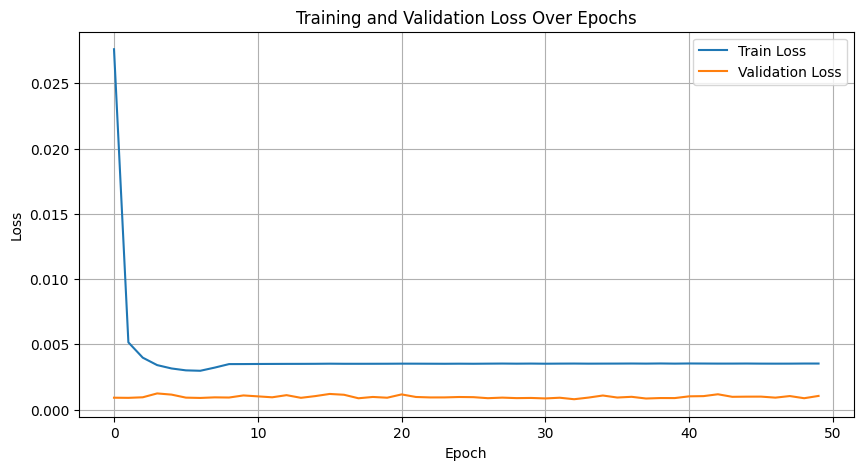

In [28]:
EPOCHS = 50
history = train_and_validate(model, criterion, optimizer, train_loader, val_loader, EPOCHS, device)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
model_path = "soc_dnn_model.pth"
torch.save({'model_state_dict': model.state_dict(), 'input_size': len(FEATURE_COLS)}, model_path)

### Testing

In [29]:
model_path = "soc_dnn_model.pth"

def load_model(model_path, input_size):
    model = SoCDNN(input_size=len(FEATURE_COLS), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])
    model.to(device)
    model.eval()
    return model

loaded_model = load_model(model_path, len(FEATURE_COLS))

In [30]:
def test_model(model, test_loader, device):
    model.eval()
    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels, _, _ in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_predictions.extend(outputs.cpu().view(-1).tolist())
            test_labels.extend(labels.cpu().view(-1).tolist())

    return test_predictions, test_labels

# Evaluate the model
test_predictions, test_labels = test_model(loaded_model, test_loader, device)

# Convert predictions and labels to numpy arrays for error calculation
test_predictions_np = np.array(test_predictions)
test_labels_np = np.array(test_labels)

In [31]:
# Calculate metrics MAE, MSE, STD
mse = mean_squared_error(test_labels_np, test_predictions_np)
mae = mean_absolute_error(test_labels_np, test_predictions_np)
stddev = np.std(test_labels_np - test_predictions_np)

print(f"Test MSE: {mse:.6f}")
print(f"Test MAE: {mae:.6f}")
print(f"Test StdDev: {stddev:.6f}")

Test MSE: 0.001864
Test MAE: 0.030187
Test StdDev: 0.040522


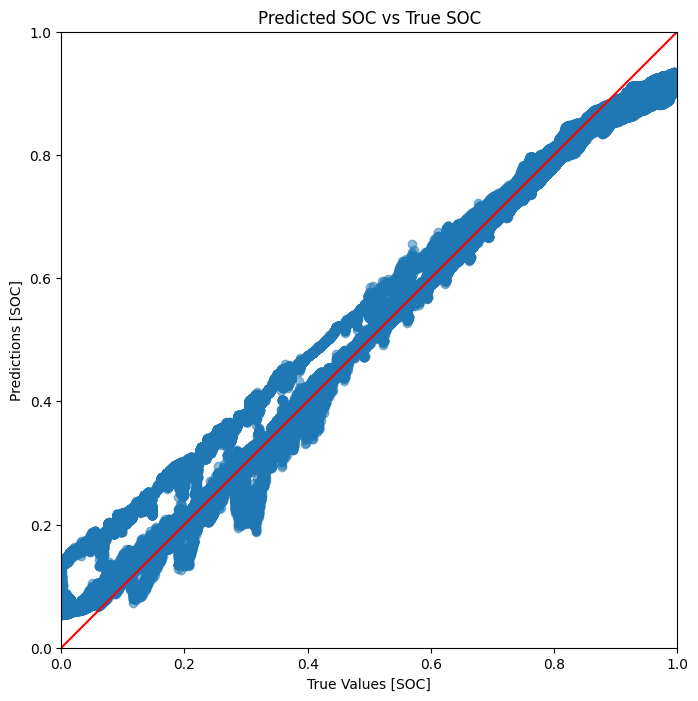

In [34]:
plt.figure(figsize=(8, 8))
plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel('True Values [SOC]')
plt.ylabel('Predictions [SOC]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1], color='red') 
plt.title('Predicted SOC vs True SOC')
plt.show()

### Qualitative Comparison

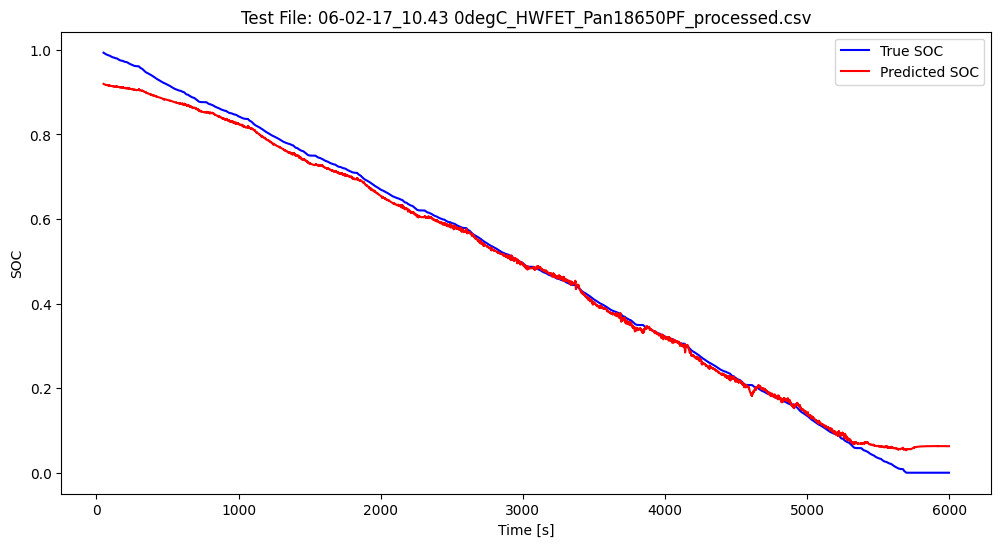

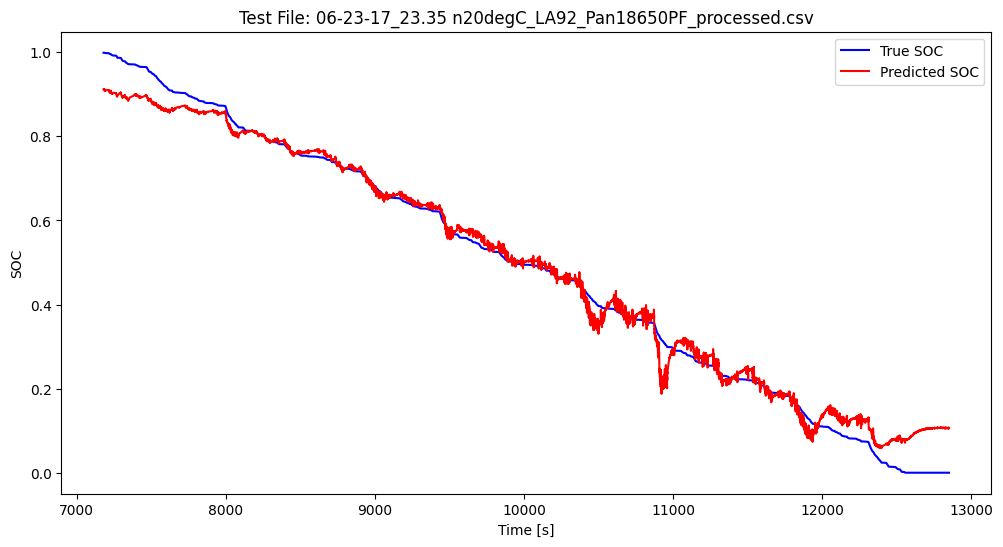

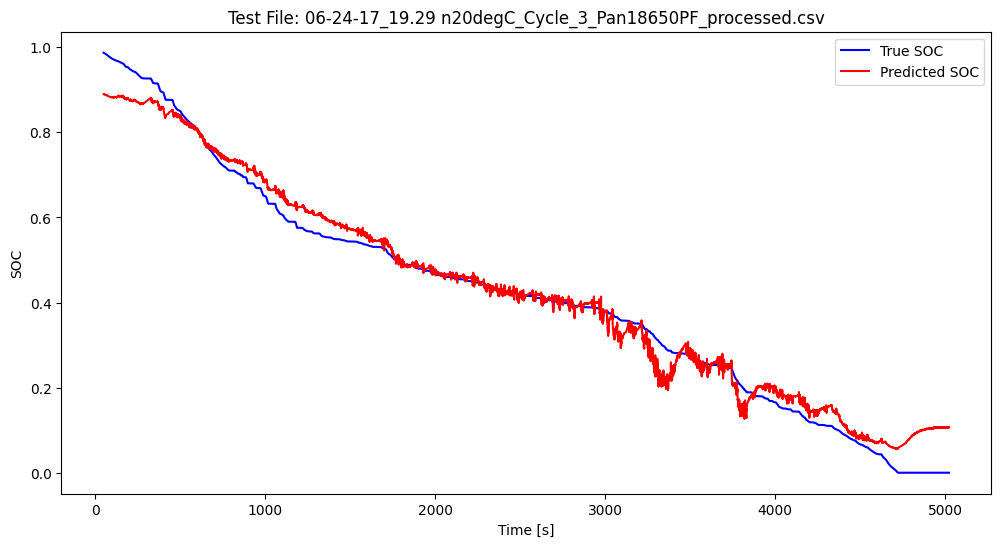

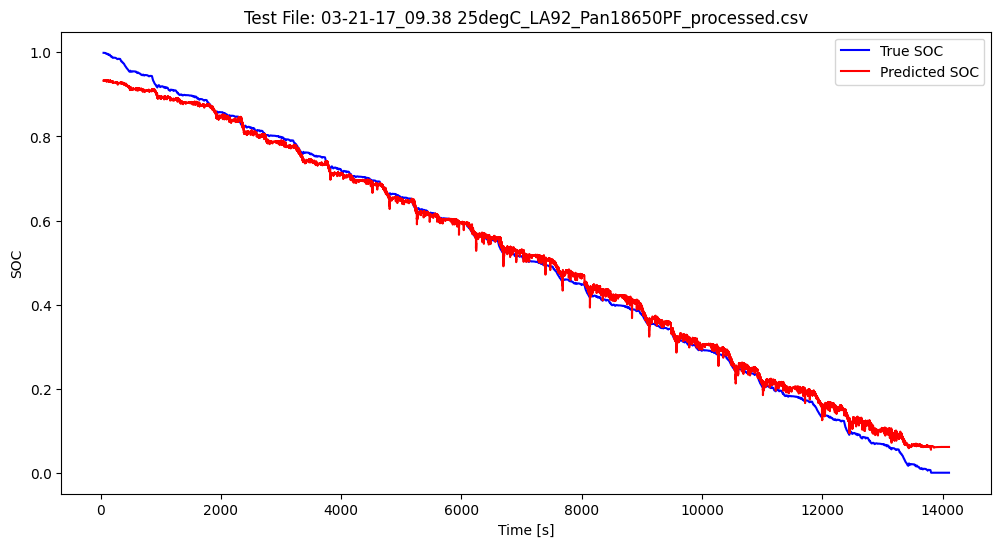

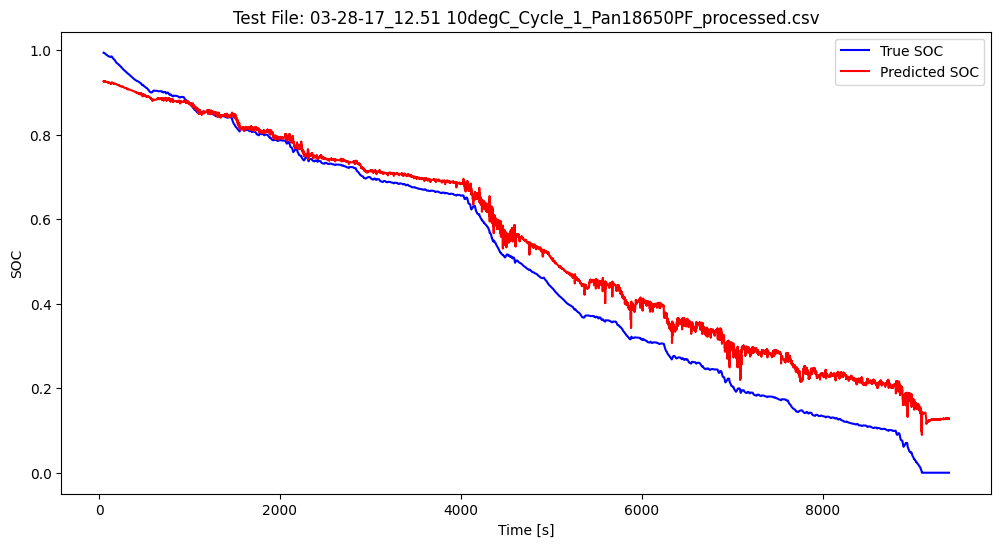

In [33]:
def test_model(model, test_loader, device):
    model.eval()
    test_results = {}

    with torch.no_grad():
        for inputs, labels, filenames, times in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = outputs.cpu().view(-1).numpy()
            labels = labels.cpu().view(-1).numpy()

            for filename, time, pred, label in zip(filenames, times, predictions, labels):
                if filename not in test_results:
                    test_results[filename] = {'times': [], 'predictions': [], 'labels': []}
                test_results[filename]['times'].append(time)
                test_results[filename]['predictions'].append(pred)
                test_results[filename]['labels'].append(label)

    return test_results

def plot_soc_over_time(test_results):
    for filename, data in test_results.items():
        times = data['times']
        predictions = data['predictions']
        labels = data['labels']

        plt.figure(figsize=(12, 6))
        plt.plot(times, labels, label='True SOC', color='blue')
        plt.plot(times, predictions, label='Predicted SOC', color='red')
        plt.title(f'Test File: {filename}')
        plt.xlabel('Time [s]')
        plt.ylabel('SOC')
        plt.legend()
        plt.show()

# Evaluate the model on the test set
test_results = test_model(loaded_model, test_loader, device)

# Plot the SOC over time for each test file
plot_soc_over_time(test_results)